# Data Processing
For this example, I'll be using the data from [RAVDESS](https://zenodo.org/record/1188976#.YfGMsFjMLX1) for speech emotion recognition. Before building out anything, we need to make the data usable and this section is to show how to formulate the data correctly.

In [1]:
import os
from typing import List

data_location = 'data'
actors = range(1, 24)
emotions = {
    'neutral': 1,
    'calm': 2,
    'happy': 3,
    'sad': 4,
    'angry': 5,
    'fearful': 6,
    'disgust': 7,
    'surprised': 8
}


def get_file_paths(actor: int, emotion: str) -> List[str]:
    folder_path = f"{os.getcwd()}/work/speech-emotion-recognizer/{data_location}/Actor_{actor:02}"

    file_names = [
        f'03-01-{emotions[emotion]:02}-01-01-01-{actor:02}.wav',
        f'03-01-{emotions[emotion]:02}-01-01-02-{actor:02}.wav',
        f'03-01-{emotions[emotion]:02}-01-02-01-{actor:02}.wav',
        f'03-01-{emotions[emotion]:02}-01-02-02-{actor:02}.wav'
    ]

    return [f"{folder_path}/{file_name}" for file_name in file_names]

### 1. Reading Data

Below is reading audio data of first file related to Author 1 - Happy

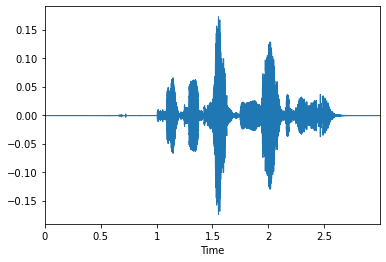

In [2]:

import librosa.display

file_paths = get_file_paths(2, 'happy')

file_path = file_paths[0]
audio_array, sampling_rate = librosa.load(file_path, duration=3)
librosa.display.waveplot(audio_array, sr=sampling_rate)

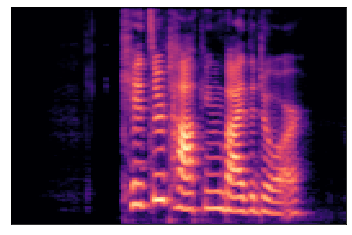

In [3]:
# Visualizing using Spectrogram
spectrogram = librosa.feature.melspectrogram(audio_array)
librosa.display.specshow(librosa.power_to_db(spectrogram))

In [4]:
spectrogram

array([[8.6743190e-09, 4.1585055e-09, 5.8921534e-09, ..., 2.7365010e-07,
        6.2106801e-07, 2.1432290e-07],
       [5.0229927e-09, 5.2159237e-09, 1.2752212e-08, ..., 6.2754697e-07,
        6.7904335e-07, 5.2462821e-07],
       [4.2040940e-09, 2.4194724e-09, 2.8943448e-09, ..., 4.1963690e-07,
        7.3120907e-07, 1.9258216e-06],
       ...,
       [1.0602488e-09, 8.3939389e-10, 1.0984655e-09, ..., 8.1769080e-09,
        1.1209059e-08, 1.1367316e-08],
       [1.8992344e-10, 2.5089922e-10, 4.4723178e-10, ..., 2.9648155e-09,
        1.7995212e-09, 2.0906348e-09],
       [2.7327713e-11, 2.2203892e-11, 2.3328148e-11, ..., 2.7136665e-10,
        1.6115759e-10, 3.8280776e-10]], dtype=float32)

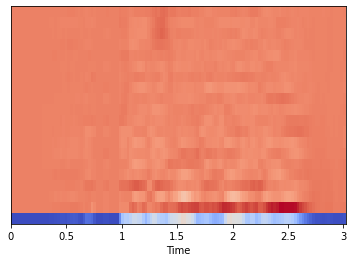

In [5]:
# Visualizing using MFCC
mfccs = librosa.feature.mfcc(audio_array)
librosa.display.specshow(mfccs, sr=sampling_rate, x_axis='time')

/opt/conda/lib/python3.9/site-packages/librosa/display.py:954: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn(


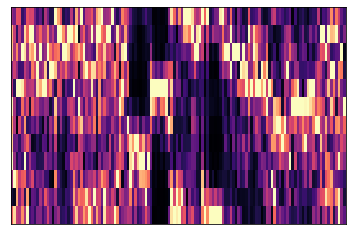

In [6]:
# Visualizing using STFT
stft = librosa.stft(audio_array)
chroma = librosa.feature.chroma_stft(S=stft, sr=sampling_rate)
librosa.display.specshow(chroma, sr=sampling_rate)

### 2. Preparing Training and Test Data

In [7]:
import numpy as np

# This variable will store file_path of the data and the emotion label
files = []
for actor in range(1, 25):
    for emotion in emotions:
        for file_path in get_file_paths(actor, emotion):
            files.append({
                'file_path': file_path,
                'emotion': emotions[emotion]
            })

import random

# Shuffling the list such that emotion and actor is randomized
random.shuffle(files)

# Building Train Data
train_size = 300
TRAIN_FEATURES = np.zeros((train_size, 128, 130))
TRAIN_LABELS = np.zeros(train_size)
print("Building Train Data")
for i in range(train_size):
    file_path = files[i]['file_path']
    label = files[i]['emotion']

    audio_array, sample_rate = librosa.load(file_path, duration=3)
    spectrogram = librosa.feature.melspectrogram(audio_array)

    feature = np.zeros((128, 130))
    feature[:spectrogram.shape[0], :spectrogram.shape[1]] = spectrogram

    TRAIN_FEATURES[i] = feature
    TRAIN_LABELS[i] = label

# Building Test Data
print("Building Test Data")
TEST_FEATURE = np.zeros((20, 128, 130))
TEST_LABELS = np.zeros(20)
for i in range(20):
    file_path = files[i + train_size]['file_path']
    label = files[i + train_size]['emotion']

    audio_array, sample_rate = librosa.load(file_path, duration=3)
    spectrogram = librosa.feature.melspectrogram(audio_array)

    feature = np.zeros((128, 130))
    feature[:spectrogram.shape[0], :spectrogram.shape[1]] = spectrogram

    TEST_FEATURE[i] = feature
    TEST_LABELS[i] = label

Building Train Data
Building Test Data


### 3. Building out the modal

In [14]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, 3, input_shape=(128, 130, 1), activation=tf.nn.relu),
    # tf.keras.layers.Conv2D(32, 3, activation=tf.nn.relu),
    # tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(9, activation=tf.nn.softmax)
])

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


In [16]:
history = model.fit(
    TRAIN_FEATURES,
    TRAIN_LABELS,
    epochs=10,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
    validation_data=(TEST_FEATURE, TEST_LABELS)
)

Epoch 1/10
10/10 [==============================] - 17s 2s/step - loss: 2.1355 - accuracy: 0.1900 - val_loss: 2.1391 - val_accuracy: 0.2000
Epoch 2/10
10/10 [==============================] - 11s 1s/step - loss: 1.9351 - accuracy: 0.4567 - val_loss: 2.1942 - val_accuracy: 0.1000
Epoch 3/10
10/10 [==============================] - 11s 1s/step - loss: 1.8222 - accuracy: 0.5600 - val_loss: 2.1272 - val_accuracy: 0.2500
Epoch 4/10
10/10 [==============================] - 11s 1s/step - loss: 1.7726 - accuracy: 0.6033 - val_loss: 2.0928 - val_accuracy: 0.3000
Epoch 5/10
10/10 [==============================] - 11s 1s/step - loss: 1.6909 - accuracy: 0.6900 - val_loss: 2.1152 - val_accuracy: 0.2500
Epoch 6/10
10/10 [==============================] - 12s 1s/step - loss: 1.6746 - accuracy: 0.7000 - val_loss: 2.1604 - val_accuracy: 0.2500
Epoch 00006: early stopping


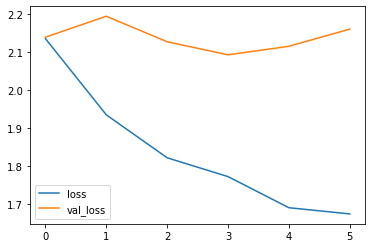

In [17]:
import matplotlib.pyplot as plt

metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()


In [18]:
model.evaluate(TEST_FEATURE, TEST_LABELS)

1/1 [==============================] - 0s 117ms/step - loss: 2.1604 - accuracy: 0.2500


[2.1603899002075195, 0.25]

In [19]:
predict = model.predict(TEST_FEATURE)
y_pred = np.argmax(predict, axis=1)
y_true = TEST_LABELS

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 25%
